In [37]:
cd ../analysis/

/srv/data/home/jlee782/final_segmentation/analysis


In [38]:
%pylab inline
%load_ext autoreload
%autoreload 2
from withClustAnalysis import *
from PixelEM import * 

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# Pick best clusters for each object sample based on MV
best_clust_df = best_worker_picking()

In [40]:
clustObj=clust_df.objid.unique()

In [41]:
def plot_best_clust_thresh_metric(metric,gt=""):
    for algo in ['GTLSA',"basic","GT","isoGT","isoGTLSA"]:
        # we only ran on the best clusters, so the results should only be on the best clusters if not -1
        data =  pd.read_csv("pixel_em/{}{}_full_PRJ_table.csv".format(gt,algo))
        data = data[((data["clust"]==-1) &(data["objid"].isin(noClust_obj)))| ((data["clust"]!=-1) & data["objid"].isin(clustObj))]
        #data = data[data["sample_num"]==0]
        plt.plot(data.groupby("num_workers").mean()[metric],label=algo)
        assert len(data.objid.unique())==len(object_lst)
    MV = pd.read_csv("pixel_em/MV_full_PRJ_table.csv") 
    #MV = MV[MV["sample_num"]==0]
    # now need to filter based on best cluster
    MV = filter_best_clust(MV,best_clust_df)
    # select only the best cluster if clustered object -1 if not clustered
    MV = MV[((MV["clust"]==-1) &(MV["objid"].isin(noClust_obj)))| ((MV["clust"]!=-1) & MV["objid"].isin(clustObj))]

    #MV[(MV["num_workers"]==5)&(MV["sample_num"]==9)].sort("objid")
    plt.plot(MV.groupby("num_workers").mean()[metric],label="MV clust")
    MV_noClust = MV[MV["clust"]==-1].groupby("num_workers").mean()[metric]
    plt.plot(MV_noClust,label="MV no clust")


    plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
    plt.ylabel(metric)
    plt.xticks(rotation=50)
    a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
    if gt:
        plt.title("Ground truth EM [best clust & thresh]",fontsize=13)
    else:
        plt.title("Binary Search Thresh EM [best clust & thresh]",fontsize=13)

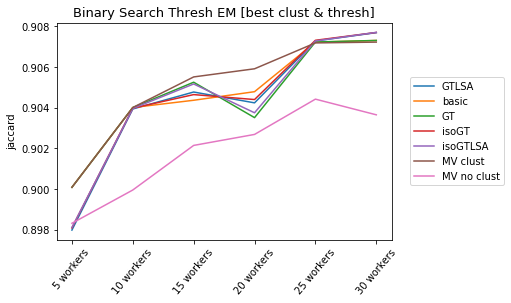

In [42]:
plot_best_clust_thresh_metric("jaccard")

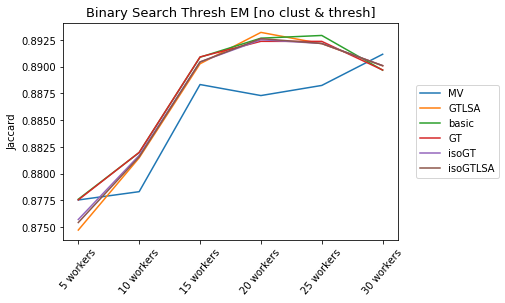

In [43]:
gt=""
MV = pd.read_csv("pixel_em/MV_full_PRJ_table.csv") 
# now need to filter based on best cluster
MV = filter_best_clust(MV,best_clust_df)
# select only the best cluster if clustered object -1 if not clustered
MV = MV[(MV["clust"]==-1)]
plt.plot(MV.groupby("num_workers").mean()["jaccard"],label="MV")

for algo in ['GTLSA',"basic","GT","isoGT","isoGTLSA"]:
    # we only ran on the best clusters, so the results should only be on the best clusters if not -1
    data =  pd.read_csv("pixel_em/{}{}_full_PRJ_table.csv".format(gt,algo))
    data = data[(data["clust"]==-1)]
    plt.plot(data.groupby("num_workers").mean()["jaccard"],label=algo)
    assert len(data.objid.unique())==len(object_lst)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Binary Search Thresh EM [no clust & thresh]",fontsize=13)

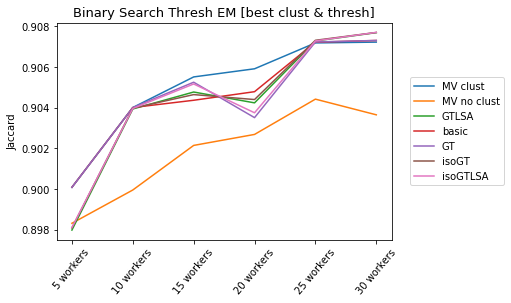

In [44]:
gt=""
MV = pd.read_csv("pixel_em/MV_full_PRJ_table.csv") 
# now need to filter based on best cluster
MV = filter_best_clust(MV,best_clust_df)
# select only the best cluster if clustered object -1 if not clustered
MV = MV[((MV["clust"]==-1) &(MV["objid"].isin(noClust_obj)))| ((MV["clust"]!=-1) & MV["objid"].isin(clustObj))]

#MV[(MV["num_workers"]==5)&(MV["sample_num"]==9)].sort("objid")
plt.plot(MV.groupby("num_workers").mean()["jaccard"],label="MV clust")
MV_noClust = MV[MV["clust"]==-1].groupby("num_workers").mean()["jaccard"]
plt.plot(MV_noClust,label="MV no clust")

for algo in ['GTLSA',"basic","GT","isoGT","isoGTLSA"]:
    # we only ran on the best clusters, so the results should only be on the best clusters if not -1
    data =  pd.read_csv("pixel_em/{}{}_full_PRJ_table.csv".format(gt,algo))
    data = data[((data["clust"]==-1) &(data["objid"].isin(noClust_obj)))| ((data["clust"]!=-1) & data["objid"].isin(clustObj))]
    plt.plot(data.groupby("num_workers").mean()["jaccard"],label=algo)
    assert len(data.objid.unique())==len(object_lst)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Binary Search Thresh EM [best clust & thresh]",fontsize=13)

In [45]:
data.groupby(["num_workers","sample_num"]).count()["jaccard"]

num_workers  sample_num
5            0             44
             1             44
             2             44
             3             44
             4             44
             5             44
             6             44
             7             44
             8             44
             9             44
10           0             44
             1             44
             2             44
             3             44
             4             44
             5             44
             6             44
             7             44
15           0             44
             1             44
             2             42
             3             24
             4             26
             5             28
20           0             44
             1             35
             2             15
             3             15
25           0             44
             1             44
30           0             44
Name: jaccard, dtype: int64

In [47]:
data[(data["clust"]==-1)&(data["objid"].isin(noClust_obj))].groupby(["num_workers","sample_num"]).count()["jaccard"]

num_workers  sample_num
5            0             21
             1             21
             2             21
             3             21
             4             21
             5             21
             6             21
             7             21
             8             21
             9             21
10           0             21
             1             21
             2             21
             3             21
             4             21
             5             21
             6             21
             7             21
15           0             21
             1             21
             2             21
             3             21
             4             21
             5             21
20           0             21
             1             21
             2             15
             3             15
25           0             21
             1             21
30           0             21
Name: jaccard, dtype: int64

In [48]:
data[data["clust"]!=-1].groupby(["num_workers","sample_num"]).count()["jaccard"]

num_workers  sample_num
5            0             23
             1             23
             2             23
             3             23
             4             23
             5             23
             6             23
             7             23
             8             23
             9             23
10           0             23
             1             23
             2             23
             3             23
             4             23
             5             23
             6             23
             7             23
15           0             23
             1             23
             2             21
             3              3
             4              5
             5              7
20           0             23
             1             14
25           0             23
             1             23
30           0             23
Name: jaccard, dtype: int64

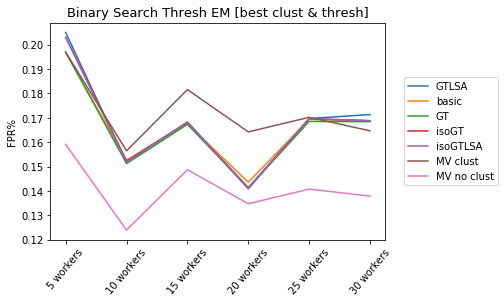

In [33]:
plot_best_clust_thresh_metric("FPR%")

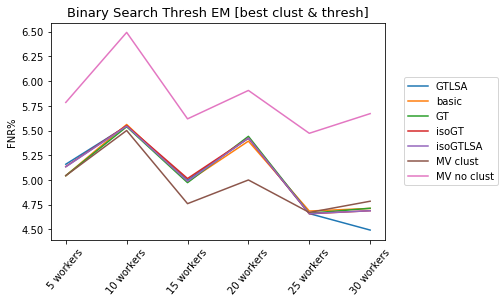

In [34]:
plot_best_clust_thresh_metric("FNR%")

In [31]:
from PixelEM import * 

In [36]:
len(clustObj)

25

In [35]:
sample_name = "5workers_rand0"
objid =5 
cluster_id = -1
do_EM_for(sample_name, objid, cluster_id="", rerun_existing=True,initMethod="0.6constant")

Doing EM
Loading time: 0.202219009399
starting with q=0.6
iteration: 0
Time for worker prob calculation: 9.53674316406e-07
{9: 0.6, 143: 0.6, 247: 0.6, 270: 0.6, 199: 0.6}
{9: array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool), 199: array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool), 143: array([[False, False, False, ..., False, False, False],
       [False, False, False, ...

IndexError: list index out of range